In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

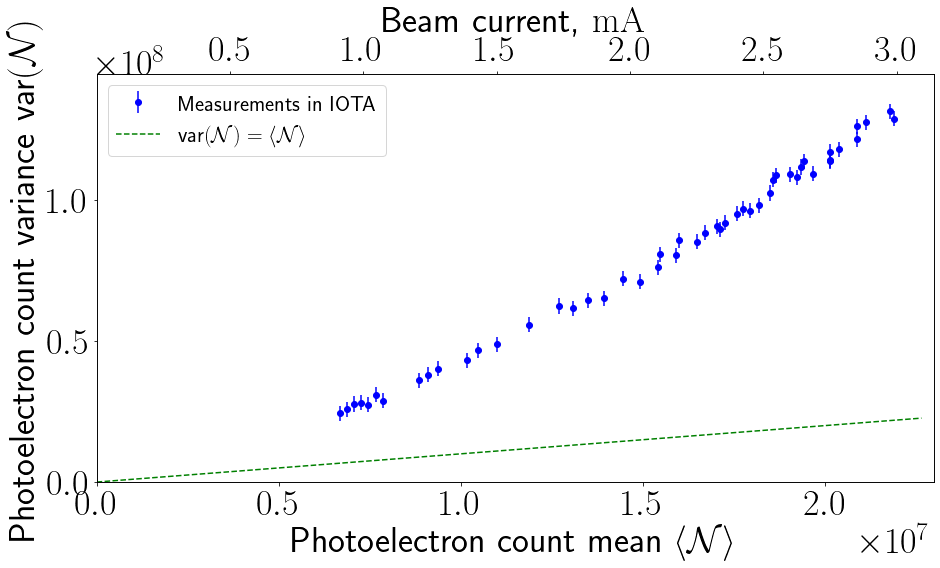

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
def f(x, alpha):
    return x+alpha*x**2
import scipy.optimize
alpha = scipy.optimize.curve_fit(f, meas_ROUND['N'], meas_ROUND['varN'])[0][0]
def NfromVarN(vn):
    return (-1+np.sqrt(1+4*alpha*vn))/2/alpha
NfromVarN(1.7e8)

24329020.288276903

In [4]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [5]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [6]:
es = df.columns.values.astype(np.float64)

In [7]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [8]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [10]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [11]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [12]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [13]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [14]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [15]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [16]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [17]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [18]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [19]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [20]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


In [21]:
lt_f_df = pd.read_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"),
            index_col=0)
lt_f_df

,I (mA),Beam life time (Sec),N,ey_rec_no_transv_acc
0,3.240886,673.919441,2.373104e+07,24.578904
1,2.984119,564.301654,2.185089e+07,15.010924
2,2.900092,540.472757,2.123561e+07,13.237524
3,2.799922,569.145127,2.050212e+07,13.832813
4,2.698333,566.514739,1.975825e+07,12.812618
5,2.595502,566.061219,1.900528e+07,11.972052
6,2.497812,568.244421,1.828996e+07,11.140308
7,2.400284,572.918800,1.757582e+07,10.409269
8,2.299991,574.791691,1.684143e+07,9.588766
9,2.200101,573.493563,1.611000e+07,8.742246


In [22]:
et_df = pd.read_csv("e_from_touschek_round.csv", index_col=0)

In [23]:

# prop = fm.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

In [24]:
import matplotlib as mpl

In [25]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

/home/ilobach/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Text(0, 0.5, 'Normal text ...')

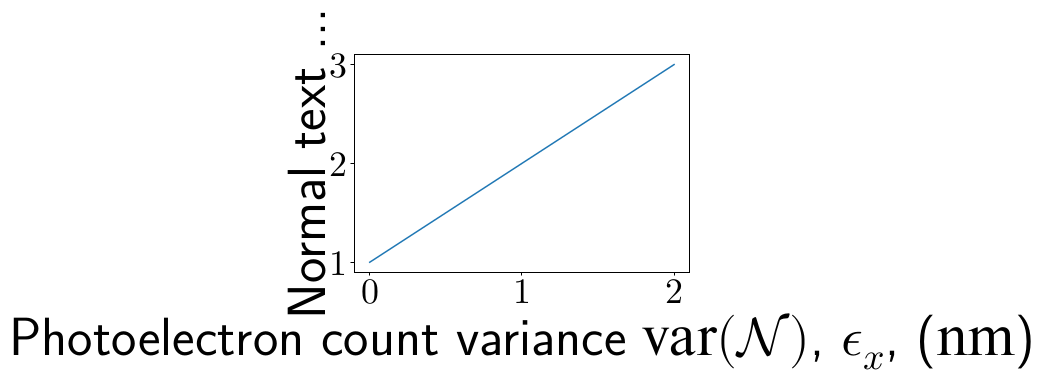

In [26]:
import matplotlib.font_manager as fm
fm._rebuild()
# -*- coding:utf-8 -*-
import matplotlib as mpl

mpl.use("pgf")

## TeX preamble
preamble = [
    r'\usepackage{amsmath}',
    r'\usepackage{unicode-math}',
    r'\usepackage{amsthm}',
    r'\setmainfont{Times}',
    r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}',
    r'\let\mathbb\relax',
    r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}',
    r'\usepackage{siunitx}'
]

params = {
#     'font.family': 'serif',
    'text.usetex': True,
#     'text.latex.unicode': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
}

mpl.rcParams.update(params)

import matplotlib.pyplot as plt

plt.plot([1, 2, 3])
plt.xlabel(r'Photoelectron count variance $\mathrm{var}(\mathcal{N})$, $\epsilon_x$, (\SI{}{nm})', fontsize=54)
plt.ylabel(r'Normal text ...', fontsize=54)

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


Remember that a small protion of SLM data at large Ibeam is extrapolated


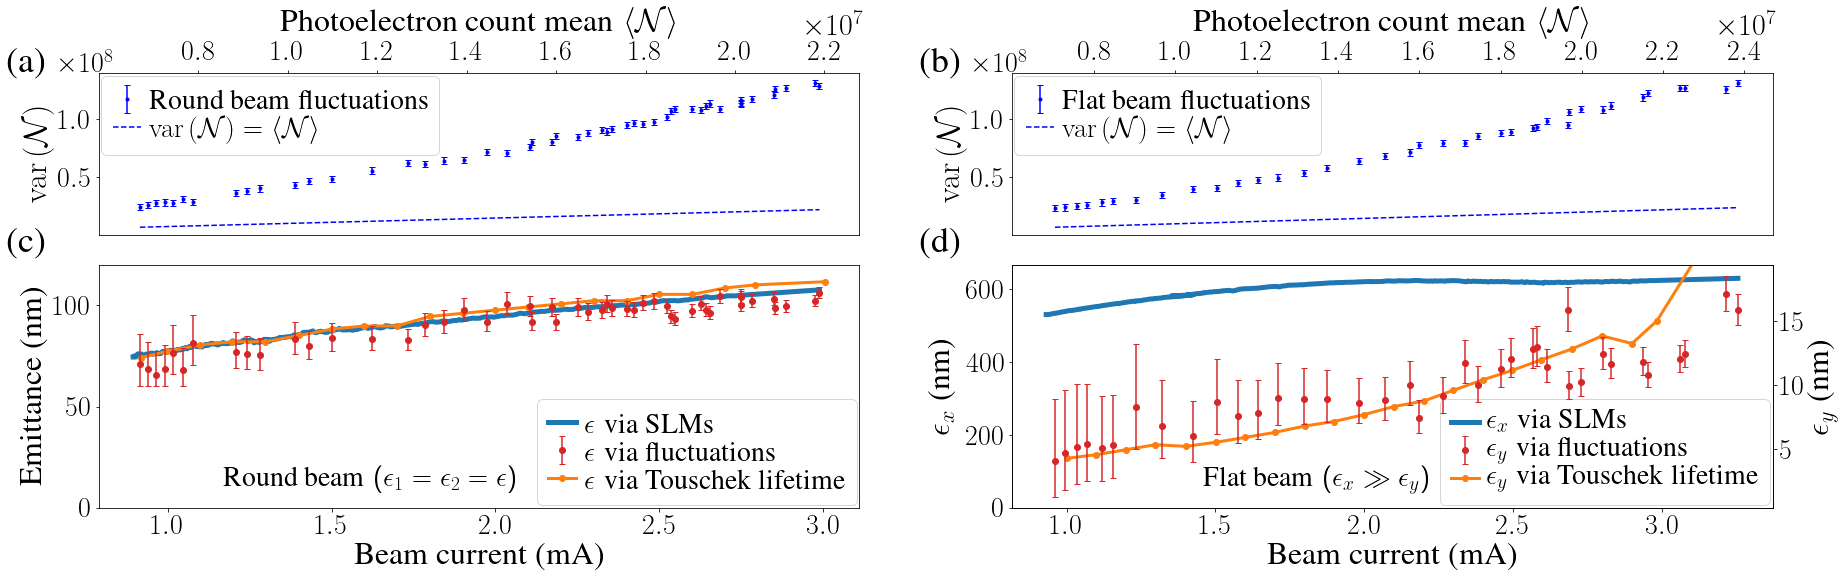

In [100]:
bap=0.1
htp = 0.3
hl = 1
powerfs = 30
powerpos = 0.93, 1.38
subtitlepos = 0.55, 0.05
subfs = 28
avNlabel = r"{\myfont Photoelectron count mean} $\langle\mathcal{N}\rangle$"
beamCurLabel = r"{\myfont Beam current (mA)}"
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
df = round_df
# plt.rc('font',**{'family':'serif','serif':['Times']})
# # mpl.rcParams["font.family"] = "serif"
# # mpl.rcParams["font.serif"] = "STIX"
# # plt.rcParams["mathtext.fontset"] = 'dejavuserif'
# plt.rcParams["mathtext.fontset"] = "custom"
# plt.rcParams["mathtext.bf"] =  "sans:bold"
# plt.rcParams["mathtext.cal"] = "sans:cursive"
# plt.rcParams["mathtext.it"] =  "sans:italic"
# plt.rcParams["mathtext.rm"] =  "sans"
# plt.rcParams["mathtext.sf"] =  "sans"
# plt.rcParams["mathtext.tt"] =  "monospace"
# # plt.rcParams["mathtext.fallback"] = "cm"
# plt.rcParams["mathtext.default"] = "it"
# rc = {"font.family" : "serif", 
#       "mathtext.fontset" : "stix"}
# plt.rcParams.update(rc)
# plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["text.usetex"] = True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand*{\myfont}{\fontfamily{ptm}\selectfont}'
#        +r'\usepackage{amsmath}'
#        +r'\usepackage{wasysym}'
#        +r'\usepackage{amssymb}'
      )
# plt.rcParams["text.latex.unicode"] = True
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 28,
                     'legend.fontsize':28,
                     'errorbar.capsize':3})
fs = 32


i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_ROUND['N'].max()/i_to_photoel],
                 'ex_um': ex_r_func(meas_ROUND['N'].max()),
                 'ey_um': ey_r_func(meas_ROUND['N'].max())
                 }),
    df], ignore_index=True)


fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [2, 3]})


photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE = ax[1][0]
axRE.text(*subtitlepos, r"{\myfont Round beam} ($\epsilon_1=\epsilon_2=\epsilon$)", transform=axRE.transAxes,
      fontsize=subfs, va='bottom', ha='right')
axRE.plot(photoel/i_to_photoel, 0.5*1000*(df['ex_um']+df['ey_um']),'-', linewidth=5 ,
        label=r'$\epsilon$ {\myfont via SLMs}')
axRE.plot(et_df['I (mA)'], 1000*et_df['e'],'.-', color='tab:orange',
                 marker='o', linewidth=3, label=r'$\epsilon$ {\myfont via Touschek lifetime}',
                zorder=99)

axRE.set_xlabel(beamCurLabel, fontsize=fs)
axRE.set_ylabel(r"{\myfont Emittance (nm)}", fontsize=fs)

color='tab:red'
yerr = 1e3*np.array([meas_ROUND['e_error_bottom'],meas_ROUND['e_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
axRE.errorbar(meas_ROUND['N']/i_to_photoel, 1e3*meas_ROUND['e_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, zorder=100,
             label=r"$\epsilon$ {\myfont via fluctuations}")
axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
handles, labels = axRE.get_legend_handles_labels()
order = [0,2,1]
# order = [0,1]
axRE.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='lower right',
#            bbox_to_anchor=(1.01,-0.045),
            borderaxespad=bap,
            labelspacing=0.0, handlelength=hl,
           handletextpad=htp)




axRF = ax[0][0]
pw=1e7
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_ROUND['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axRF.errorbar(meas_ROUND['N']/pw, meas_ROUND['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'{\myfont Round beam fluctuations}')
axRF.plot(meas_ROUND['N']/pw, meas_ROUND['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axRF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
axRF.set_xlabel(avNlabel, fontsize=fs)
handles, labels = axRF.get_legend_handles_labels()
order = [1,0]
axRF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left',borderaxespad=bap,
            labelspacing=0.0, handlelength=hl,
           handletextpad=htp)
axRF.set_xlim(np.asarray(axRE.get_xlim())*i_to_photoel/pw)
axRF.xaxis.tick_top()
axRF.xaxis.set_label_position('top') 
axRF.set_xticks(ticks=axRF.get_xticks()[2:-1])
axRF.text(*powerpos, r"$\times\SI{e7}{}$", transform=axRF.transAxes,
      fontsize=powerfs, fontweight='bold', va='top', ha='left')
axRF.get_yaxis().get_offset_text().set_x(-0.05)
axRF.xaxis.labelpad = 10




axFE = ax[1][1]
axFE.set_ylabel(r"$\epsilon_x$ {\myfont (nm)}", fontsize=fs)

df = flat_df


# extrapolation:
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_FLAT['N'].max()/i_to_photoel],
                 'ex_um': ex_f_func(meas_FLAT['N'].max())}),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ln1 = axFE.plot(photoel/i_to_photoel, 1000*df['ex_um'],
                    '-', linewidth=5, label=r'$\epsilon_x$ {\myfont via SLMs}', zorder=99)
axFE.set_ylim(0, 1.05*axFE.get_ylim()[1])
axFE.text(*subtitlepos, r"{\myfont Flat beam} ($\epsilon_x\gg\epsilon_y$)", transform=axFE.transAxes,
      fontsize=subfs, va='bottom', ha='right')
axFE.set_xlabel(beamCurLabel, fontsize=fs)

axFEy = axFE.twinx()
color='tab:red'
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ln2 = axFEy.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\epsilon_y$ {\myfont via fluctuations}',
                    zorder=100)

yrange = axFEy.get_ylim()

ln3 = axFEy.plot(lt_f_df['I (mA)'], lt_f_df['ey_rec_no_transv_acc'],
                '.-', color='tab:orange',
                 marker='o', linewidth=3, label=r'$\epsilon_y$ {\myfont via Touschek lifetime}',
                zorder=1)

axFEy.set_ylim(yrange)

axFEy.set_ylabel(r"$\epsilon_y$ {\myfont (nm)}", fontsize=fs)

lns = [ln1[0], ln2, ln3[0]]
labs = [l.get_label() for l in lns]
axFE.legend(lns, labs, loc='lower right',
#            bbox_to_anchor=(1.01,-0.045),
           borderaxespad=bap,
            labelspacing=0.0, handlelength=hl,
           handletextpad=htp)




axFF = ax[0][1]
pw=1e7
meas_FLAT = \
    pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'),
                index_col=0)
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_FLAT['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axFF.errorbar(meas_FLAT['N']/pw,meas_FLAT['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'{\myfont Flat beam fluctuations}')
axFF.plot(meas_FLAT['N']/pw, meas_FLAT['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axFF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
axFF.set_xlabel(avNlabel, fontsize=fs)
handles, labels = axFF.get_legend_handles_labels()
order = [1,0]
axFF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left',borderaxespad=bap,
            labelspacing=0.0, handlelength=hl,
           handletextpad=htp)
axFF.set_xlim(np.asarray(axFE.get_xlim())*i_to_photoel/pw)
axFF.xaxis.tick_top()
axFF.xaxis.set_label_position('top')
axFF.set_xticks(ticks=np.arange(0.8,2.41,0.2))
axFF.text(*powerpos, r"$\times\SI{e7}{}$", transform=axFF.transAxes,
      fontsize=powerfs, fontweight='bold', va='top', ha='left')
axFF.get_yaxis().get_offset_text().set_x(-0.05)
axFF.xaxis.labelpad = 10


fig.subplots_adjust(hspace=0.15)
for i, label in enumerate(('(a)', '(b)', '(c)', '(d)')):
    x = i // 2
    y = i - 2*x
    axx = ax[x][y] 
    axx.text(-0.12, 1.15, r"{\myfont "+label+r"}", transform=axx.transAxes,
      fontsize=36, va='top', ha='left')
print("Remember that a small protion of SLM data at large Ibeam is extrapolated")
plt.savefig(path_assistant.get_PRL_images_dir().fi("iota_measurements.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [27]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prab"))
plt.rc('pgf', preamble=r'\usepackage{amsmath}\usepackage{unicode-math}\usepackage{amsthm}\setmainfont{Times}\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}\let\mathbb\relax\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       r'\usepackage{siunitx}')

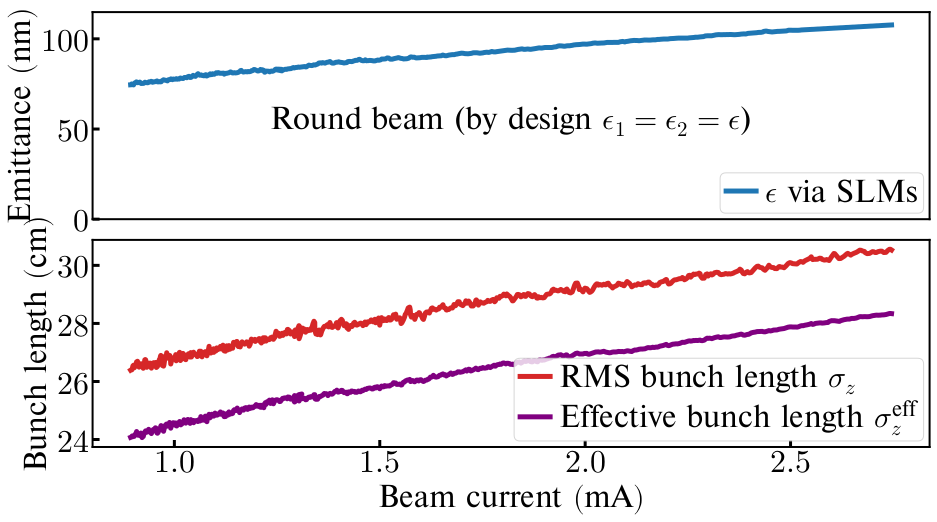

In [29]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axRE, ax2 = axs
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = round_df
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute': [-meas_ROUND['N'].max()/i_to_photoel],
                  'ex_um': ex_r_func(meas_ROUND['N'].max()),
                  'ey_um': ey_r_func(meas_ROUND['N'].max())
                  }),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE.text(0.5, 0.4, r"Round beam (by design $\epsilon_1=\epsilon_2=\epsilon$)", transform=axRE.transAxes, va='bottom', ha='center')
axRE.plot(photoel/i_to_photoel, 0.5*1000*(df['ex_um']+df['ey_um']), '-', linewidth=5,
          label=r'$\epsilon$ via SLMs')
# axRE.plot(photoel/i_to_photoel, 1000*df['ey_um'],'-', linewidth=5 ,
#         label=r'$\epsilon_y$ via SLMs')


axRE.set_ylabel(r"Emittance $(\SI{}{nm})$")

axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
axRE.legend(loc='lower right')
axRE.get_xaxis().set_visible(False)

ax2.plot(photoel/i_to_photoel, df['N:IWCMBR'], '-', linewidth=5,
         label=r'RMS bunch length $\sigma_z$', color='tab:red')
ax2.plot(photoel/i_to_photoel, df['N:IWCMBE'], '-', linewidth=5,
         label=r'Effective bunch length $\sigma_z^{\mathrm{eff}}$',
         color='purple')
ax2.legend(loc='lower right')
ax2.set_ylabel("Bunch length $(\SI{}{cm})$")
ax2.set_yticks(ticks=np.arange(24, 31, 2))


ax2.set_xlabel(r"Beam current $(\SI{}{mA})$")
# ax2.set_ylim(0, 1.05*ax2.get_ylim()[1])
fig.subplots_adjust(hspace=0.1)
plt.savefig(path_assistant.get_PRL_images_dir().fi("ex_ey_round_beam.png"),
            dpi=300, bbox_inches='tight')
plt.show()